In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/homefs/home/wongfanc/density-ratio-estimation/gb1-models/'

# load ground-truth landscape

160000 160000 (160000, 4, 21)


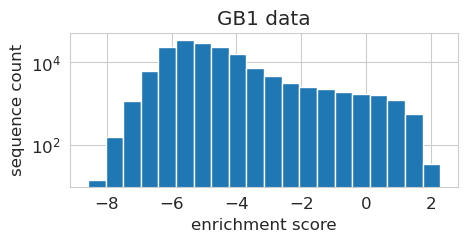

In [2]:
# binding affinity values (y_n) for all 20^4 = 160k variants (seq_n) of 4 sites of the GB1 protein
df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()
var_n = df['estimated_variance'].to_numpy()

# seq2yvar maps every possible length-4 amino acid sequence to a list of two floats,
# the sequence's enrichment score and the estimated variance of the enrichment score
# (the latter was used for training the model, but isn't used after we've trained the model, can ignore)
seq2yvar = {seq: [y, var] for seq, y, var in zip(seq_n, y_n, var_n)}

# one-hot-encodings of all 20^4 sequences
ohe_nxlxa = np.stack([str2onehot(seq, gb1.AA) for seq in seq_n])
print(len(seq_n), y_n.size, ohe_nxlxa.shape)

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

# load model and design distributions

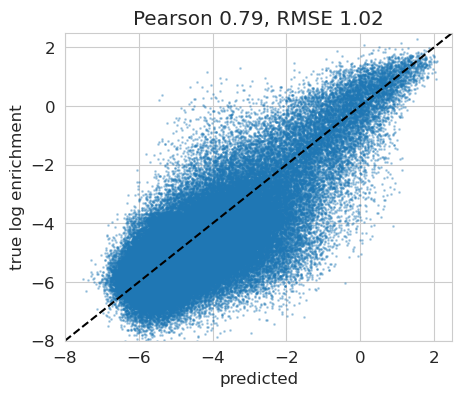

In [5]:
reload(gb1)
reload(models)

n_hidden = 10
n_model = 3
device = torch.device(0)

model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('gb1-h10-5k-030123')

# load all design distributions.
# temp2theta is a dictionary that maps real-valued temperature to the corresponding
# design distribution, which is parameterized by a (seq_len X 4) matrix called theta_lxa.
# each row of theta_lxa gives the logits of a categorical distribution over the 4 nucleotides
# at a site. there are a total of seq_len nucleotide sites, where
# seq_len = (# protein residues) * 3 because there are 3 nucleotides per codon,
# and (# protein residues) = 4 for this dataset.
temperatures = np.arange(0.2, 0.701, 0.001)
temp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

# true mean labels of design distributions
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta) 

# sanity-check: plot model predictions on all data
pred_n = model.predict(seq_n)
plt.figure(figsize=(5, 4))
plt.scatter(pred_n, y_n, alpha=0.3, s=1)
plt.plot([-8, 2.5], [-8, 2.5], '--k')
r, p = sc.stats.pearsonr(y_n, pred_n)
rmse = np.sqrt(np.mean(np.square(y_n - pred_n)))

plt.ylim([-8, 2.5]);
plt.xlim([-8, 2.5])
plt.title('Pearson {:.2f}, RMSE {:.2f}'.format(r, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

# sample sequences from a design distribution

Sampled 10000 design sequences for temperature 0.400 (0 s).

Example design sequences:
['vqga', 'vsaa', 'ikga', 'isaa', 'fraa', 'lyaa', 'ikaa', 'lraa', 'fcaa', 'lfaa']

True mean label of this design distribution: 0.979.

Sampled 10000 training sequences from NNK distribution (0 s).

Example training distribution sequences:
['lwlt', 'kmls', 'tkwl', 'tvnt', 'sfys', 'kcti', 'vlsr', 'rlir', 'mtks', 'pfrg']


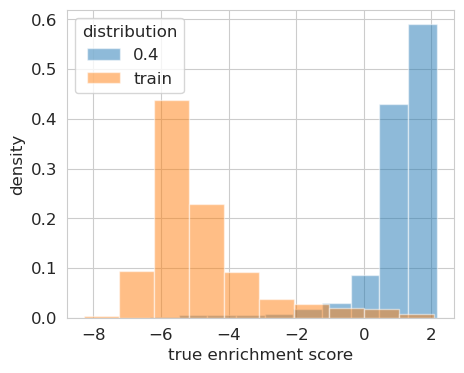

In [23]:
# temperature of interest
# (all possible temperatures defined in 'temperatures' variable in above cell)
temp = 0.4
# desired number of samples
n_sample = 10000

# fetch design distribution parameters theta_lxa corresponding to this temperature
theta_lxa = temp2theta[round(temp, 4)]

# sample from this design distribution.
# the i-th element of designohe_nxlxa is the one-hot-encoded (seq_len x alphabet_size) = (4 x 20)
# representation of the i-the element of designseq_n, which is the length-4 sequence as a str.
t0 = time()
_, designohe_nxlxa, designseq_n = gb1.sample_ohe_from_nuc_distribution(
    theta_lxa, n_sample, normalize=True, reject_stop_codon=True
)
print('Sampled {} design sequences for temperature {:.3f} ({} s).\n'.format(
    n_design, temp, int(time() - t0)
))
print('Example design sequences:')
print(designseq_n[: 10])
print()
print('True mean label of this design distribution: {:.3f}.\n'.format(temp2mean[round(temp, 4)]))

# get true labels of design sequences
ydesign_n = np.array([seq2yvar[seq][0] for seq in designseq_n])

# get samples and true labels from training distribution, for reference
_, trainohe_nxlxa, trainseq_n = gb1.sample_ohe_from_nuc_distribution(
    gb1.PNUC_NNK_LXA, n_sample, normalize=False, reject_stop_codon=True
)
print('Sampled {} training sequences from NNK distribution ({} s).\n'.format(n_sample, int(time() - t0)))
print('Example training distribution sequences:')
print(trainseq_n[: 10]) 

# get true labels of train sequences
ytrain_n = np.array([seq2yvar[seq][0] for seq in trainseq_n])

# plot
plt.figure(figsize=(5, 4))
plt.hist(ydesign_n, density=True, alpha=0.5, label=temp)
plt.hist(ytrain_n, density=True, alpha=0.5, label='train')
plt.xlabel('true enrichment score');
plt.ylabel('density')
plt.legend(title='distribution'); 